In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

os.chdir('../..')

from src.utils_k import add_type_features
from src.utils_r import generate_validation_set

pd.options.display.max_columns = 9999
pd.options.display.max_rows = 9999

In [2]:
from src.utils_f import duration_feature
from src.utils_k import add_more_features
from src.utils_f import add_page
from src.utils_k import add_action
from src.utils_r import add_num_skus
import lightgbm as lgbm
import re

In [3]:
%load_ext autoreload
%autoreload 2

In [58]:
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
all_session = pd.read_csv('data/raw/train_session.csv') 
all_tracking = pd.read_csv('data/raw/train_tracking.csv')
product = pd.read_feather('data/processed/product_modify.feather')

 24%|██▍       | 2556942/10635919 [03:20<10:32, 12768.87it/s]/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [92]:
train_buy = pd.merge(all_tracking, all_session, how='left', on='sid')
prod_sku = train_buy.loc[(all_tracking.ocarproducts.notnull()) |
                         (all_tracking.products.notnull()) |
                         (all_tracking.oproducts.notnull()) |
                         (all_tracking.carproducts.notnull())][['sku', 'target']].reset_index()
prod_cat = pd.merge(prod_sku, product, left_on='sku', right_on='product_id')

dict_prod = prod_cat.set_index('product_id').to_dict('index')

level_1 = prod_cat.groupby('category_product_id_level1').count().to_dict('index')
level_map_1 = prod_cat.groupby(['category_product_id_level1', 'target']).count().to_dict('index')

cats = prod_cat.category_product_id_level1.unique()

for cat in cats:
    if row_prod.product_id in dict_prod:
        if (dict_prod[row_prod.product_id]['category_product_id_level1'], True) in level_map_1:
            product.at[ix, 'SCORE_LEVEL_1'] = level_map_1[(dict_prod[row_prod.product_id]['category_product_id_level1'], True)]['sku'] * 1.0 / level_1[(dict_prod[row_prod.product_id]['category_product_id_level1'])]['sku'] 
         

for ix, row_prod in tqdm(product.iterrows(), total=len(product)):
    if row_prod.product_id in dict_prod:
        if (dict_prod[row_prod.product_id]['category_product_id_level1'], True) in level_map_1:
            product.at[ix, 'SCORE_LEVEL_1'] = level_map_1[(dict_prod[row_prod.product_id]['category_product_id_level1'], True)]['sku'] * 1.0 / level_1[(dict_prod[row_prod.product_id]['category_product_id_level1'])]['sku'] 
            


  3%|▎         | 350066/10635919 [00:28<13:45, 12454.42it/s]

KeyboardInterrupt: 

In [59]:
all_tracking = pd.merge(all_tracking, product, how='left', left_on='sku', right_on='product_id')
test_tracking = pd.merge(test_tracking, product, how='left', left_on='sku', right_on='product_id')

In [60]:
all_tracking = add_action(all_tracking)
all_tracking = add_page(all_tracking)
test_tracking = add_action(test_tracking)
test_tracking = add_page(test_tracking)

In [61]:
trn_session, trn_tracking, val_session, val_tracking = generate_validation_set(all_session, all_tracking, test_size=0.4)

In [62]:
proc_train = add_type_features(trn_session[['sid']], trn_tracking)
proc_val = add_type_features(val_session[['sid']], val_tracking)
proc_all = add_type_features(all_session[['sid']], all_tracking)
proc_test = add_type_features(test_session, test_tracking)

In [63]:
proc_train = add_more_features(proc_train, trn_tracking)
proc_val = add_more_features(proc_val, val_tracking)
proc_all = add_more_features(proc_all, all_tracking)
proc_test = add_more_features(proc_test, test_tracking)

In [67]:


def add_prod_f(df, all_data):
    t = all_data[['sid', 'stype']].dropna()
    temp = pd.get_dummies(t, columns=['stype'])
    temp_stype = temp.groupby('sid').sum().to_dict('index')
    aux = all_data[['sid', 'rate', 'rvoter', 'rh', 'rw', 'rcount']]
    ok = aux.groupby('sid')
    temp_max = ok.max().to_dict('index')
    temp_mean = ok.mean().to_dict('index')
    temp_min = ok.min().to_dict('index')
    
    temp_sum = all_data[['sid', 'quantity', 'ff']].groupby('sid').sum().to_dict('index')

    df['sname_mean'] = np.nan
    df['sname_max'] = np.nan
    df['rate_mean'] = np.nan
    df['rate_min'] = np.nan
    df['rate_max'] = np.nan
    df['rv_mean'] = np.nan
    df['rv_min'] = np.nan
    df['rv_max'] = np.nan
    df['val_levl1'] = np.nan
    df['rh'] = np.nan
    df['rw'] = np.nan
    df['quan'] = 0.0
    df['ff_total'] = np.nan
    df['cdis_total'] = 0.0
    df['mar_total'] = 0.0
    df['rcount_mean'] = 0.0
    df['rcount_min'] = 0.0
    df['rcount_max'] = 0.0
    for ix, row in (df.iterrows()):#, total=len(df)):
        if row.sid in temp_mean:

            df.at[ix, 'rate_mean'] = temp_mean[row.sid]['rate']
            df.at[ix, 'rate_min'] = temp_min[row.sid]['rate']
            df.at[ix, 'rate_max'] = temp_max[row.sid]['rate']
            df.at[ix, 'rv_mean'] = temp_mean[row.sid]['rvoter']
            df.at[ix, 'rv_min'] = temp_min[row.sid]['rvoter']
            df.at[ix, 'rv_max'] = temp_max[row.sid]['rvoter']
            df.at[ix, 'val_levl1'] = temp_mean[row.sid]['SCORE_LEVEL_1']
            df.at[ix, 'rh'] = temp_mean[row.sid]['rh']
            df.at[ix, 'rw'] = temp_mean[row.sid]['rw']
            df.at[ix, 'rcount_mean'] = temp_mean[row.sid]['rcount']
            df.at[ix, 'rcount_min'] = temp_min[row.sid]['rcount']
            df.at[ix, 'rcount_max'] = temp_max[row.sid]['rcount']
            df.at[ix, 'quan'] = temp_sum[row.sid]['quantity']
            df.at[ix, 'ff_total'] = temp_sum[row.sid]['ff']
        if row.sid in temp_stype:
            df.at[ix, 'cdis_total'] = temp_stype[row.sid]['stype_i40+rMlxCCxz1hgpPEHVCw==']
            df.at[ix, 'mar_total'] = temp_stype[row.sid]['stype_nH9oPdOoBjQ6KgoScH5o4Q==']
            


In [68]:
add_prod_f(proc_train, trn_tracking)
add_prod_f(proc_val, val_tracking)
add_prod_f(proc_all, all_tracking)
add_prod_f(proc_test, test_tracking)

In [69]:
proc_train = duration_feature(proc_train, trn_tracking)
proc_val = duration_feature(proc_val, val_tracking)
proc_all = duration_feature(proc_all, all_tracking)
proc_test = duration_feature(proc_test, test_tracking)


/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [70]:
add_num_skus(proc_train, trn_tracking)
add_num_skus(proc_val, val_tracking)
add_num_skus(proc_all, all_tracking)
add_num_skus(proc_test, test_tracking)

In [71]:
from src.utils_f import purchased_products

In [72]:
proc_train = purchased_products(proc_train, trn_tracking)
proc_val = purchased_products(proc_val, val_tracking)
proc_all = purchased_products(proc_all, all_tracking)
proc_test = purchased_products(proc_test, test_tracking)

In [95]:
add_session_metadata(proc_train, trn_tracking)
add_session_metadata(proc_val, val_tracking)
add_session_metadata(proc_all, all_tracking)
add_session_metadata(proc_test, test_tracking)

/anaconda/envs/kaggle/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [102]:

process_cats(proc_all, proc_test, ['device', 'siteid'])

In [104]:
proc_all.head()

,sid,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,CAROUSEL_page,LIST_PRODUCT_page,LP_page,LR_page,PA_page,SEARCH_page,SHOW_CASE_page,UNKNOWN_page,SUM_PAGE_page,ADD_TO_BASKET_action,NONE_action,PRODUCT_action,PURCHASE_PRODUCT_action,SUM_ACTION_action,sname_mean,sname_max,rate_mean,rate_min,rate_max,rv_mean,rv_min,rv_max,val_levl1,rh,rw,quan,ff_total,cdis_total,mar_total,rcount_mean,rcount_min,rcount_max,TOTAL_DURATION,NUM_SKUS,PURCHASED_PRODUCTS,device,siteid
0,U6clt0UYaQB7vJQFmSWYymsAfwmT9SMhrm2oXQ8TC5M8mf...,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.00,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,4.0,0.0,0.250000,0.0,0.00,0.250000,0.0,0.500000,0.0,4.0,0.250000,0.0,0.0,0.250000,0.00,0.500000,0.0,0.0,4.0,0.0,0.750000,0.250000,0.0,4.0,NaN,NaN,3.6,3.6,3.6,17.0,17.0,17.0,NaN,718.0,1440.0,0.0,0.0,1.0,0.0,36.000000,34.0,40.0,4159.908524,1,NaN,1,2
1,0qRbLkxeOjeEo6CtxtB6VI8FNPt4Vl8niySzZLqSWiQOka...,0.0,0.0,0.0,0.0,0.0,0.307692,0.0,0.00,0.076923,0.0,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.384615,0.0,13.0,0.0,0.307692,0.0,0.00,0.307692,0.0,0.384615,0.0,13.0,0.384615,0.0,0.0,0.230769,0.00,0.384615,0.0,0.0,13.0,0.0,0.692308,0.307692,0.0,13.0,NaN,NaN,4.1,3.2,4.6,70.5,5.0,131.0,NaN,681.0,1391.0,0.0,0.0,4.0,0.0,23.750000,3.0,61.0,565.958263,3,NaN,1,2
2,cnCRGomfPqEWuhMZkA0RQfvTQiwVoyHXUqvqnPCutVouFO...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,4.0,0.0,0.000000,0.0,0.25,0.250000,0.0,0.500000,0.0,4.0,0.000000,0.0,0.0,0.250000,0.25,0.500000,0.0,0.0,4.0,0.0,0.750000,0.250000,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,670.0,1366.0,0.0,0.0,0.0,1.0,111.333333,0.0,167.0,215.217049,1,NaN,1,2
3,zBwrofN0r2ps9u/UCUS134SiZIqB+UgIEr0MZGHzksqR4f...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,4.0,0.0,0.000000,0.0,0.00,0.000000,0.0,1.000000,0.0,4.0,0.000000,0.0,0.0,0.000000,0.00,1.000000,0.0,0.0,4.0,0.0,1.000000,0.000000,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,825.0,1600.0,0.0,0.0,0.0,0.0,139093.000000,54.0,278141.0,75.088516,0,NaN,1,2
4,Kbr60r9eaX/ENOJ81R1YBxfwrEohoxyQI9Ma0fODsS+/XN...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,3.0,0.0,0.000000,0.0,0.00,0.000000,0.0,1.000000,0.0,3.0,0.000000,0.0,0.0,0.000000,0.00,1.000000,0.0,0.0,3.0,0.0,1.000000,0.000000,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,631.0,1366.0,0.0,0.0,0.0,0.0,132.000000,132.0,132.0,38.080125,0,NaN,1,2


In [74]:
proc_train.shape

(79873, 67)

# Validation

In [75]:
X_train = proc_train.drop('sid', axis=1).reset_index(drop=True)
y_train = trn_session.target.reset_index(drop=True)

X_val = proc_val.drop('sid', axis=1).reset_index(drop=True)
y_val = val_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)

temp_columns = X_train.columns
X_val = X_val[temp_columns]
X_test = X_test[temp_columns]

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[X_train.columns[:32]])
X_train_sc = scaler.transform(X_train[X_train.columns[:32]])
X_val_sc = scaler.transform(X_val[X_val.columns[:32]])

In [77]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 11).fit(X_train_sc)

X_train_pca = (pca.transform(X_train_sc))
X_val_pca = (pca.transform(X_val_sc))

X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train_pca)], axis=1)
X_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(X_val_pca)], axis=1)

In [78]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 6,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=800, verbose_eval=100)

[100]	valid_0's binary_logloss: 0.284375
[200]	valid_0's binary_logloss: 0.277956
[300]	valid_0's binary_logloss: 0.27538
[400]	valid_0's binary_logloss: 0.274114
[500]	valid_0's binary_logloss: 0.273478
[600]	valid_0's binary_logloss: 0.273265
[700]	valid_0's binary_logloss: 0.273097
[800]	valid_0's binary_logloss: 0.273015


In [79]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=800, verbose_eval=100)

[100]	valid_0's binary_logloss: 0.28443
[200]	valid_0's binary_logloss: 0.277958
[300]	valid_0's binary_logloss: 0.275258
[400]	valid_0's binary_logloss: 0.27401
[500]	valid_0's binary_logloss: 0.273402
[600]	valid_0's binary_logloss: 0.273194
[700]	valid_0's binary_logloss: 0.273011
[800]	valid_0's binary_logloss: 0.272916


# Model

In [105]:
X_all = proc_all.drop('sid', axis=1).reset_index(drop=True)
y_all = all_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)
temp_columns = X_all.columns
X_test = X_test[temp_columns]

In [106]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_all[X_all.columns[:32]])
X_all_sc = scaler.transform(X_all[X_all.columns[:32]])
X_test_sc = scaler.transform(X_test[X_test.columns[:32]])

In [107]:
pca = PCA(n_components = 11).fit(X_all_sc)

X_all_pca = pd.DataFrame(pca.transform(X_all_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

X_all = pd.concat([pd.DataFrame(X_all), pd.DataFrame(X_all_pca)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_test_pca)], axis=1)

In [108]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_all, label=y_all)

clf = lgbm.train(params, d_train, 
                num_boost_round=800)

KeyboardInterrupt: 

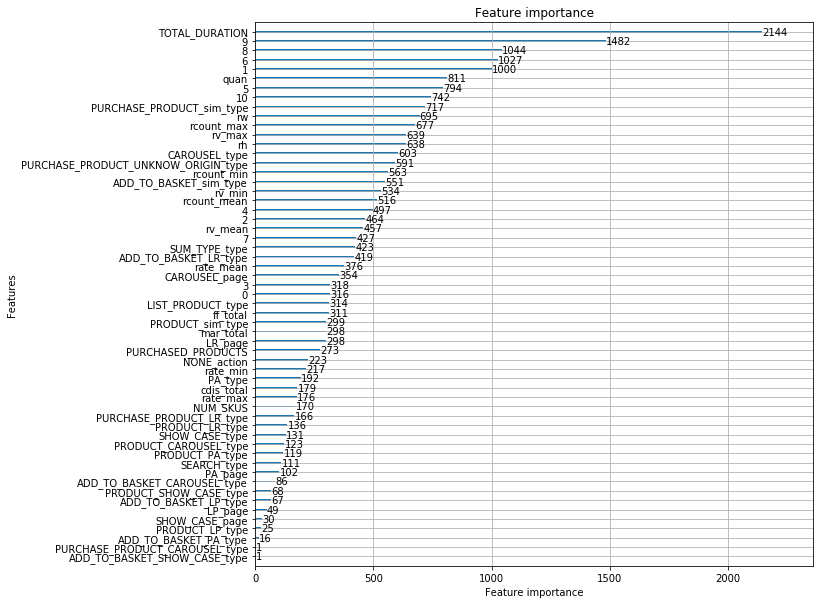

In [84]:
from matplotlib import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 10, 10
lgbm.plot_importance(clf)

In [86]:
count += 1
preds=clf.predict(X_test)
test_session['target'] = preds
test_session.to_csv(f'data/submissions/kervy_{count}_submit.csv', index=False)

In [85]:
count = 19

In [109]:
from src.utils_r import to_cat_codes, apply_cats

def process_cats(proc_train, proc_val, cat_cols):
    to_cat_codes(proc_train, cat_cols)
    apply_cats(proc_val, proc_train)
    for df in [proc_train, proc_val]:
        for col in cat_cols:
            df[col] = df[col].cat.codes
    proc_train['device'] = proc_train.device + 1
    proc_val['device'] = proc_val.device + 1

In [112]:
X_all.drop('PURCHASED_PRODUCTS', axis=1, inplace=True)
X_test.drop('PURCHASED_PRODUCTS', axis=1, inplace=True)

In [126]:
list(X_all.columns).index('devic')

66

In [128]:
from src.utils_j import test_catboost
from catboost import CatBoostClassifier
catboost_test_preds = test_catboost(CatBoostClassifier(iterations=1000, 
                                random_seed=42, eval_metric='Logloss'), 
                                X_all,
                                   y_all, 
                                   X_test, 
                                   test_size=0.15, 
                                   random_seeds=[5, 17, 45, 125, 305], 
                                   cat_features=[list(X_all.columns).index('siteid'), list(X_all.columns).index('device')])[0]

No. estimators: 143 | Train log loss: 0.2579430192493584 | Val log loss: 0.2673098571744645
No. estimators: 111 | Train log loss: 0.26174807868783734 | Val log loss: 0.2608102217835564
No. estimators: 173 | Train log loss: 0.257000965638517 | Val log loss: 0.2643120363840946
No. estimators: 135 | Train log loss: 0.2576775590624298 | Val log loss: 0.27549061278942827
No. estimators: 153 | Train log loss: 0.2572372559433118 | Val log loss: 0.2704124733455405

Train logloss: 25.83 +/- 0.35 | Val logloss: 26.77 +/- 1.01



In [93]:
from src.utils_r import add_session_metadata

In [133]:
test_session['target'] = catboost_test_preds * 0.25 + sub5.target * 0.75 
test_session.to_csv(f'data/submissions/gato_bost.csv', index=False)

In [91]:
test_session['target'] = catboost_test_preds
test_session.to_csv(f'data/submissions/kervy_submit_cat.csv', index=False)

In [130]:
sub5 = pd.read_csv('data/submissions/robert_5_submit_blend.csv')

In [ ]:
catboost_test_preds